<a href="https://colab.research.google.com/github/Zedbog/Data_science_course/blob/main/PROJEKT_PRAKTYCZNY_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
# podpięcie Google One Drive
drive.mount("/content/drive")\

Mounted at /content/drive


In [ ]:
link = "drive.google.com/file/d/1L3q_KJX7OS_-1g8eV3c_fvPfpYy581sj/view?usp=sharing"
link_id = link.split("/")[-2]
!gdown --id $link_id
!unzip img_align_celeba.zip

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
 extracting: img_align_celeba/197600.jpg  
 extracting: img_align_celeba/197601.jpg  
 extracting: img_align_celeba/197602.jpg  
 extracting: img_align_celeba/197603.jpg  
 extracting: img_align_celeba/197604.jpg  
 extracting: img_align_celeba/197605.jpg  
 extracting: img_align_celeba/197606.jpg  
 extracting: img_align_celeba/197607.jpg  
 extracting: img_align_celeba/197608.jpg  
 extracting: img_align_celeba/197609.jpg  
 extracting: img_align_celeba/197610.jpg  
 extracting: img_align_celeba/197611.jpg  
 extracting: img_align_celeba/197612.jpg  
 extracting: img_align_celeba/197613.jpg  
 extracting: img_align_celeba/197614.jpg  
 extracting: img_align_celeba/197615.jpg  
 extracting: img_align_celeba/197616.jpg  
 extracting: img_align_celeba/197617.jpg  
 extracting: img_align_celeba/197618.jpg  
 extracting: img_align_celeba/197619.jpg  
 extracting: img_align_celeba/197620.jpg  
 extracting: img_align_celeba/19

In [ ]:
import keras
import pandas as pd
import numpy as np
from tensorflow.keras.applications import EfficientNetB0
from keras.datasets import cifar100
from keras.models import Sequential
from keras.layers import UpSampling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from google.colab.patches import cv2_imshow
import cv2
import imgaug.augmenters as iaa
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from keras.callbacks import EarlyStopping
import plotly.graph_objects as go

In [ ]:
# Load data
data_attr = pd.read_csv('/content/drive/MyDrive/16_PROJEKT_PRAKTYCZNY_CV/list_attr_celeba.csv')
# -> etykiety atrybutów dla każdego obrazu. Istnieje 40 atrybutów. „1” oznacza obecność danego atrybutu, a „-1” oznacza brak atrybutu

data_bbox = pd.read_csv('/content/drive/MyDrive/16_PROJEKT_PRAKTYCZNY_CV/list_bbox_celeba.csv') 
# -> informacje o obwiedni dla każdego obrazu. „x1” i „y1”reprezentują współrzędne lewego górnego punktu prostokąta ograniczającego. „szerokość” i „wysokość” oznaczają szerokość i wysokość obwiedni

data_eval = pd.read_csv('/content/drive/MyDrive/16_PROJEKT_PRAKTYCZNY_CV/list_eval_partition.csv')  
# -> Zalecane partycjonowanie obrazów na zestawy uczące,walidacyjne, testowe. Obrazy 1-162770 to trenowanie, 162771-182637 to walidacja, 182638-202599 to testy

data_land = pd.read_csv('/content/drive/MyDrive/16_PROJEKT_PRAKTYCZNY_CV/list_landmarks_align_celeba.csv')
# -> unkty orientacyjne obrazu i ich odpowiedniewspółrzędne. Jest 5 punktów orientacyjnych: lewe oko, prawe oko, nos, lewe usta, prawe usta

In [ ]:
data_attr.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,1,-1,1,-1,-1,1,-1,-1,1,-1,-1,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1,-1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,1,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,-1,-1,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [ ]:
data_bbox.head()

,image_id,x_1,y_1,width,height
0,000001.jpg,95,71,226,313
1,000002.jpg,72,94,221,306
2,000003.jpg,216,59,91,126
3,000004.jpg,622,257,564,781
4,000005.jpg,236,109,120,166


In [ ]:
data_land.head()

,image_id,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
0,000001.jpg,69,109,106,113,77,142,73,152,108,154
1,000002.jpg,69,110,107,112,81,135,70,151,108,153
2,000003.jpg,76,112,104,106,108,128,74,156,98,158
3,000004.jpg,72,113,108,108,101,138,71,155,101,151
4,000005.jpg,66,114,112,112,86,119,71,147,104,150


In [ ]:
data_eval.head()

,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


In [ ]:
!pwd

/content


In [ ]:
# eda.py

class Dataset:
  def __init__(self,
                list_attr_celeba_path="/content/drive/MyDrive/16_PROJEKT_PRAKTYCZNY_CV/list_attr_celeba.csv",
                list_bbox_celeba_path="/content/drive/MyDrive/16_PROJEKT_PRAKTYCZNY_CV/list_bbox_celeba.csv",
                list_eval_partition_path="/content/drive/MyDrive/16_PROJEKT_PRAKTYCZNY_CV/list_eval_partition.csv",
                list_landmarks_align_celeba_path="/content/drive/MyDrive/16_PROJEKT_PRAKTYCZNY_CV/list_landmarks_align_celeba.csv",
                images_path="img_align_celeba/"
                ):

      list_attr_celeba = pd.read_csv(list_attr_celeba_path)
      list_bbox_celeba = pd.read_csv(list_bbox_celeba_path)
      list_eval_partition = pd.read_csv(list_eval_partition_path)
      list_landmarks_align_celeba = pd.read_csv(list_landmarks_align_celeba_path)

      df = list_attr_celeba.merge(list_bbox_celeba, on='image_id')
      df = df.merge(list_bbox_celeba, on='image_id')
      df = df.merge(list_eval_partition, on='image_id')
      self.df = df.merge(list_landmarks_align_celeba, on='image_id')
      self.images_path = images_path

  def generate_report(self, report_name='your_report'):
      profile = ProfileReport(self.df, title="Pandas Profiling Report")
      profile.to_file(f"{report_name}.html")

  def show_some_examples(self, attribute: str, positive: bool = True):
      """
      Quick visualization of some examples

      :param attribute: One of boolean attribute:
      '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
      'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows','Chubby', 'Double_Chin', 'Eyeglasses',
      'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache',
      'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks',
      'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
      'Wearing_Necklace', 'Wearing_Necktie', 'Young'
      :type attribute: str
      :param positive: show positive examples or not (negative if false)
      :type positive: boolean
      :return: None
      :rtype: None
      """
      print(self.df.columns)
      if positive:
          exist = 1
      else:
          exist = -1

      df = self.df[self.df[attribute] == exist]
      images = list(df.head(9)['image_id'])
      images = [cv2.imread(self.images_path+path) for path in images]
      horizontal_1 = np.concatenate((images[0], images[1], images[2]), axis=1)
      horizontal_2 = np.concatenate((images[3], images[4], images[5]), axis=1)
      horizontal_3 = np.concatenate((images[6], images[7], images[8]), axis=1)
      vertical = np.concatenate((horizontal_1, horizontal_2, horizontal_3), axis=0)

      cv2_imshow(vertical)

      # do pycharm
      # cv2.imshow("Examples", vertical)

      # cv2.waitKey(0)
      # cv2.destroyAllWindows()

In [ ]:
# DataGenerator


class DataGenerator(keras.utils.Sequence):
    """Generates data for Keras"""

    def __init__(self, images, labels, batch_size=64, shuffle=False, augment=False):
        self.labels = labels  # array of labels
        self.images = images  # array of images
        self.batch_size = batch_size  # batch size
        self.shuffle = shuffle  # shuffle bool
        self.augment = augment  # augment data bool
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.images) / self.batch_size))

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.images))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        'Generate one batch of data'
        # selects indices of data for next batch
        indexes = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]

        # select data and load images
        labels = np.array([self.labels[k] for k in indexes])
        # images = np.array([self.images[k] for k in indexes])
        # images = np.array([np.array(cv2.imread(self.images[k])) for k in indexes])
        images = np.array([np.array(cv2.imread("img_align_celeba/" + self.images[k])) for k in indexes]) 

        # preprocess and augment data
        if self.augment:
            images = self.augmentor(images)

        images = images / 255
        return images, labels

    @staticmethod
    def augmentor(images):
        """Apply data augmentation"""
        def sometimes(aug):
            return iaa.Sometimes(0.5, aug)
        list_of_aumgenters = []
        list_of_aumgenters.extend([sometimes(iaa.Crop(px=(1, 16), keep_size=True)),
                                   sometimes(iaa.Fliplr(0.5)),
                                   sometimes(iaa.GaussianBlur(sigma=(0, 3.0)))])

        seq = iaa.Sequential(list_of_aumgenters)

        return seq.augment_images(images)

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young', 'x_1_x', 'y_1_x', 'width_x', 'height_x',
       'x_1_y', 'y_1_y', 'width_y', 'height_y', 'partition', 'lefteye_x',
       'lefteye_y', 'righteye_x', 'righteye_y', 'nose_x', 'nose_y',
       'leftmouth_x', 'leftmouth_y', 'rightmouth_x', 'rightmouth_y'],
      dtype='object')


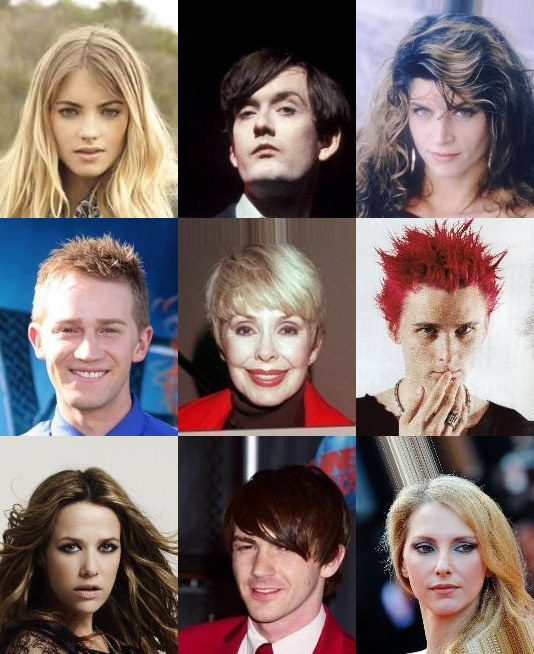

In [ ]:
# Wyświetlenie przykładowych zdjęć o określonym  atrybucie
dataset = Dataset()
dataset.show_some_examples(attribute="Pale_Skin", positive=True)

In [ ]:
X = data_attr.image_id.to_numpy().reshape(-1)
y = data_attr.Male.replace(-1, 0).to_numpy().reshape(-1)

In [ ]:
X

array(['000001.jpg', '000002.jpg', '000003.jpg', ..., '202597.jpg',
       '202598.jpg', '202599.jpg'], dtype=object)

In [ ]:
y

array([0, 0, 1, ..., 1, 0, 0])

In [ ]:
# Weryfikacja rozmiaru zdjęcia
cv2.imread('img_align_celeba/000001.jpg').shape

(218, 178, 3)

In [ ]:
# Podział na dane treningowe i testowe
train_x, test_x, train_y, test_y = train_test_split(X, y, random_state=42, test_size=0.2)

In [ ]:
print("train_x", train_x.shape)
print("train_y", train_y.shape)
print("---------")
print("test_x",test_x.shape)
print("test_y",test_y.shape)

train_x (162079,)
train_y (162079,)
---------
test_x (40520,)
test_y (40520,)


In [ ]:
# Implementacja CNN

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(218, 178, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='sigmoid'))


opt = keras.optimizers.SGD(lr=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Generator danych
generator_train = DataGenerator(images=train_x, labels=train_y, batch_size=64,  shuffle=True, augment=False)  

generator_test = DataGenerator(images=test_x, labels=test_y, batch_size=64,  shuffle=True, augment=False)  

es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

history = model.fit_generator(generator_train, epochs=5, verbose=True,  # 50
                              validation_data=generator_test,
                              callbacks = [es])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/5
2532/2532 [==============================] - 530s 209ms/step - loss: 0.3068 - accuracy: 0.8630 - val_loss: 0.1020 - val_accuracy: 0.9613
Epoch 2/5
2532/2532 [==============================] - 530s 209ms/step - loss: 0.0908 - accuracy: 0.9662 - val_loss: 0.0871 - val_accuracy: 0.9672
Epoch 3/5
2532/2532 [==============================] - 529s 209ms/step - loss: 0.0702 - accuracy: 0.9741 - val_loss: 0.0730 - val_accuracy: 0.9735
Epoch 4/5
2532/2532 [==============================] - 529s 209ms/step - loss: 0.0542 - accuracy: 0.9802 - val_loss: 0.0772 - val_accuracy: 0.9718
Epoch 5/5
2532/2532 [==============================] - 529s 209ms/step - loss: 0.0448 - accuracy: 0.9840 - val_loss: 0.0660 - val_accuracy: 0.9759


In [ ]:
# wykres pokazujący  dokładność i funkcje starty
def plot_hist(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
 
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['accuracy'], name='accuracy', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_accuracy'], name='val_accuracy', mode='markers+lines'))
    fig.update_layout(width=1000, height=500, title='Accuracy vs. Val Accuracy', xaxis_title='Epoki', yaxis_title='Accuracy', yaxis_type='log')
    fig.show()
 
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['loss'], name='loss', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_loss'], name='val_loss', mode='markers+lines'))
    fig.update_layout(width=1000, height=500, title='Loss vs. Val Loss', xaxis_title='Epoki', yaxis_title='Loss', yaxis_type='log')
    fig.show()
 
plot_hist(history)

# Testowanie na nowych zdjęciach

In [ ]:
# pobranie nowych zdjęć
# zdjecie 1
link = "https://drive.google.com/file/d/1hS4JP1VWag97D34oanyHwdHLNgtkPXHh/view?usp=sharing"
link_id = link.split("/")[-2]
!gdown --id $link_id

# zdjecie 2
link = "https://drive.google.com/file/d/1qgaVYc9dxkXrg64owwrOA-UkjN2QoIil/view?usp=sharing"
link_id = link.split("/")[-2]
!gdown --id $link_id

# zdjecie 3
link = "https://drive.google.com/file/d/1Wl_fnyUm-4NcanxCpQgul9n05eqt3pb8/view?usp=sharing"
link_id = link.split("/")[-2]
!gdown --id $link_id

# zdjecie 4
link = "https://drive.google.com/file/d/1hjIk4GZWhHxY-eKPeIEFTGzHo5prYo1A/view?usp=sharing"
link_id = link.split("/")[-2]
!gdown --id $link_id

# zdjecie 5
link = "https://drive.google.com/file/d/1kkogHoUYcxHPUR4ymF-30Z50iKM-mzFZ/view?usp=sharing"
link_id = link.split("/")[-2]
!gdown --id $link_id

Downloading...
From: https://drive.google.com/uc?id=1hS4JP1VWag97D34oanyHwdHLNgtkPXHh
To: /content/kot.jpg
100% 18.4k/18.4k [00:00<00:00, 16.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1qgaVYc9dxkXrg64owwrOA-UkjN2QoIil
To: /content/kobieta.jpg
100% 540k/540k [00:00<00:00, 79.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Wl_fnyUm-4NcanxCpQgul9n05eqt3pb8
To: /content/man3.jpg
100% 4.98k/4.98k [00:00<00:00, 4.69MB/s]
Downloading...
From: https://drive.google.com/uc?id=1hjIk4GZWhHxY-eKPeIEFTGzHo5prYo1A
To: /content/man5.jpg
100% 86.5k/86.5k [00:00<00:00, 30.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1kkogHoUYcxHPUR4ymF-30Z50iKM-mzFZ
To: /content/man4.jpg
100% 6.03k/6.03k [00:00<00:00, 4.99MB/s]


In [ ]:
# Funkcja wyświetlająca wczytane zdjecie oraz określająca  płeć 

def woman_or_man(img):
  img_row = cv2.imread(img)
  img = cv2.resize(img_row, (178,218))
  cv2_imshow(img)
  img = img.reshape(1, 218, 178, 3)
  if model.predict(img)[0][0] == 1:
    print("meżczyzna")
  else:
    print("NIE meżczyzna")

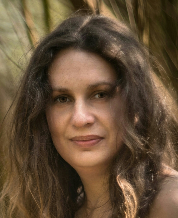

NIE meżczyzna


In [ ]:
woman_or_man("kobieta.jpg")

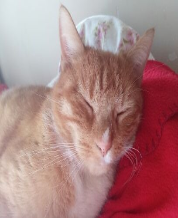

NIE meżczyzna


In [ ]:
woman_or_man("kot.jpg")

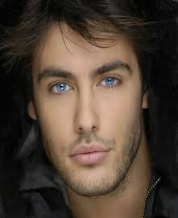

meżczyzna


In [ ]:
woman_or_man("man3.jpg")

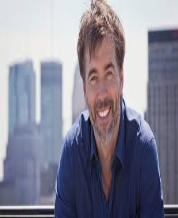

meżczyzna


In [ ]:
woman_or_man("man4.jpg")

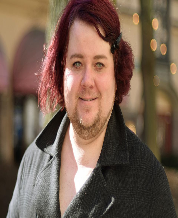

meżczyzna


In [ ]:
woman_or_man("man5.jpg")